In [1]:
# Import library and data:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
raw = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False)
data = raw.copy()
data.shape

(320772, 162)

#### Nettoyage - Filtres pertinents pour l'étude:

In [2]:
# Suppression COLONNES non pertinentes pour la qualification de produit sain:
data = data.drop(['url','creator','created_t','created_datetime','last_modified_t', 'last_modified_datetime',
                 'image_url','image_small_url','stores','ingredients_text','purchase_places','cities_tags','cities',
                 'first_packaging_code_geo','emb_codes_tags','emb_codes','labels_fr','labels_tags','labels',
                 'manufacturing_places_tags','manufacturing_places','origins_tags','origins','packaging',
                 'packaging_tags','carbon-footprint_100g','code','states_fr','states_tags','states',
                 'additives','additives_fr','ingredients_that_may_be_from_palm_oil_tags','ingredients_from_palm_oil_tags'],
                 axis='columns')
data.shape

(320772, 128)

In [3]:
# Suppression des COLONNES en doublons portant la même information:
data = data.drop(['brands_tags','categories_fr','allergens_fr','traces_tags','traces_fr',
                  'categories','main_category',
                  'categories_tags','additives_tags','countries','countries_tags'], 
                 axis='columns')
data.shape

(320772, 117)

In [4]:
# Filtre sur les produits vendus en France:
data = data[data['countries_fr'].notna()] #suppr. NaN
data = data[data['countries_fr'].str.lower().str.contains("france")] #filtre France
data.shape

(98440, 117)

In [5]:
# Suppression COLONNE 'nutrition-score-uk_100g': on utilise 'nutrition-score-fr_100g'
data = data.drop('nutrition-score-uk_100g', axis='columns')
data.shape

(98440, 116)

In [6]:
# Suppression des LIGNES sans nom de produit:
data = data[data['product_name'].notnull()]
data.shape

(91247, 116)

#### Gestion des valeurs aberrantes

In [7]:
# Recherche valeurs extremes:
data.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,nutrition-score-fr_100g,glycemic-index_100g,water-hardness_100g
count,0.0,53400.000000,53400.000000,0.0,53400.000000,0.0,0.0,6.422200e+04,30.000000,47290.000000,...,34.000000,27.000000,40.000000,2969.000000,164.000000,677.000000,0.0,61072.000000,0.0,0.0
mean,NaN,1.857060,0.069850,NaN,0.148352,NaN,NaN,1.170739e+03,547.471667,13.330031,...,1.495912,0.130522,6.559910,31.567689,15.414634,49.102363,NaN,8.678543,NaN,NaN
std,NaN,2.561931,0.258617,NaN,0.450945,NaN,NaN,1.286997e+04,574.728341,16.930537,...,5.749501,0.168218,1.672411,32.055693,3.764383,19.177248,NaN,9.044405,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000,...,0.003000,0.001800,0.000000,0.000000,8.000000,6.000000,NaN,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,4.270000e+02,62.900000,1.300000,...,0.020000,0.035000,6.275000,0.000000,12.000000,31.000000,NaN,1.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,1.035000e+03,208.500000,6.800000,...,0.027000,0.038000,7.000000,24.000000,15.000000,48.000000,NaN,9.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1.649000e+03,881.500000,21.000000,...,0.046250,0.220500,7.355000,51.000000,15.000000,65.000000,NaN,15.000000,NaN,NaN
max,NaN,31.000000,2.000000,NaN,5.000000,NaN,NaN,3.251373e+06,1830.000000,380.000000,...,33.300000,0.423000,8.400000,100.000000,25.000000,100.000000,NaN,40.000000,NaN,NaN


In [8]:
# Suppression LIGNES de 'nutrition facts' contenant des valeurs > 100g ou <0g :
L = []
k = 0
for x in data.loc[:,'fat_100g':'iron_100g'].columns:
    if (data.loc[:,x]>100).value_counts()[0] < data.shape[0]: 
        k += (data.loc[:,x]>100).value_counts()[1]
        L.extend(list(data[x][data[x]>100].index))
    if (data.loc[:,x]<0).value_counts()[0] < data.shape[0]: 
        k += (data.loc[:,x]<0).value_counts()[1]
        L.extend(list(data[x][data[x]<0].index))
assert(len(L)==k)

data = data.drop(L, axis='index')
data.shape

(91234, 116)

In [9]:
# Suppression LIGNES de 'nutrition facts' ayant une valeur de 
# colonne parente > somme des colonnes filles:
L = []

# Glucides: categorie parent: carbohydrates_100g
df = data[['carbohydrates_100g']][data['carbohydrates_100g'].notna()]
df['somme_glucides'] = data[['sugars_100g','sucrose_100g','glucose_100g','starch_100g',
          'fructose_100g','lactose_100g','maltose_100g','maltodextrins_100g']].sum(axis=1)
L.extend(list(df[df['somme_glucides']>df['carbohydrates_100g']].index))

# Lipides: categorie parent: fat_100g
df = data[['fat_100g']][data['fat_100g'].notna()]
df['somme_lipides'] = data[['saturated-fat_100g','butyric-acid_100g','caproic-acid_100g',
          'capric-acid_100g','lauric-acid_100g','myristic-acid_100g','palmitic-acid_100g',
          'stearic-acid_100g','arachidic-acid_100g','behenic-acid_100g','lignoceric-acid_100g',
          'cerotic-acid_100g','montanic-acid_100g','melissic-acid_100g','monounsaturated-fat_100g',
          'polyunsaturated-fat_100g','omega-3-fat_100g','alpha-linolenic-acid_100g',
          'eicosapentaenoic-acid_100g','docosahexaenoic-acid_100g','omega-6-fat_100g',
          'linoleic-acid_100g','arachidonic-acid_100g','gamma-linolenic-acid_100g',
          'dihomo-gamma-linolenic-acid_100g','omega-9-fat_100g','oleic-acid_100g','caprylic-acid_100g',
          'elaidic-acid_100g','gondoic-acid_100g','mead-acid_100g','erucic-acid_100g',
          'nervonic-acid_100g','trans-fat_100g']].sum(axis=1)
L.extend(list(df[df['somme_lipides']>df['fat_100g']].index))

#Sels mineraux: categorie parent: salt_100g
# data[data['salt_100g']<data['sodium_100g']].shape  #there is no wrong data here

data = data.drop(L, axis='index')
data.shape

(90536, 116)

In [10]:
# Suppression LIGNES d'énergie démesurée: unité kJ: seuil max fixé à 50000 kJ 
# (besoin journalier d'un homme moyen est 10000)

data = data.drop(list(data[data['energy_100g']>50000].index), axis='index')
data.shape

(90534, 116)

In [11]:
# Correction pour le 'pnns_groups_1': suppression '-' et mise en majuscule:
data['pnns_groups_1'] = data['pnns_groups_1'].str.replace('-',' ').str.capitalize()

#### Gestion des NaN

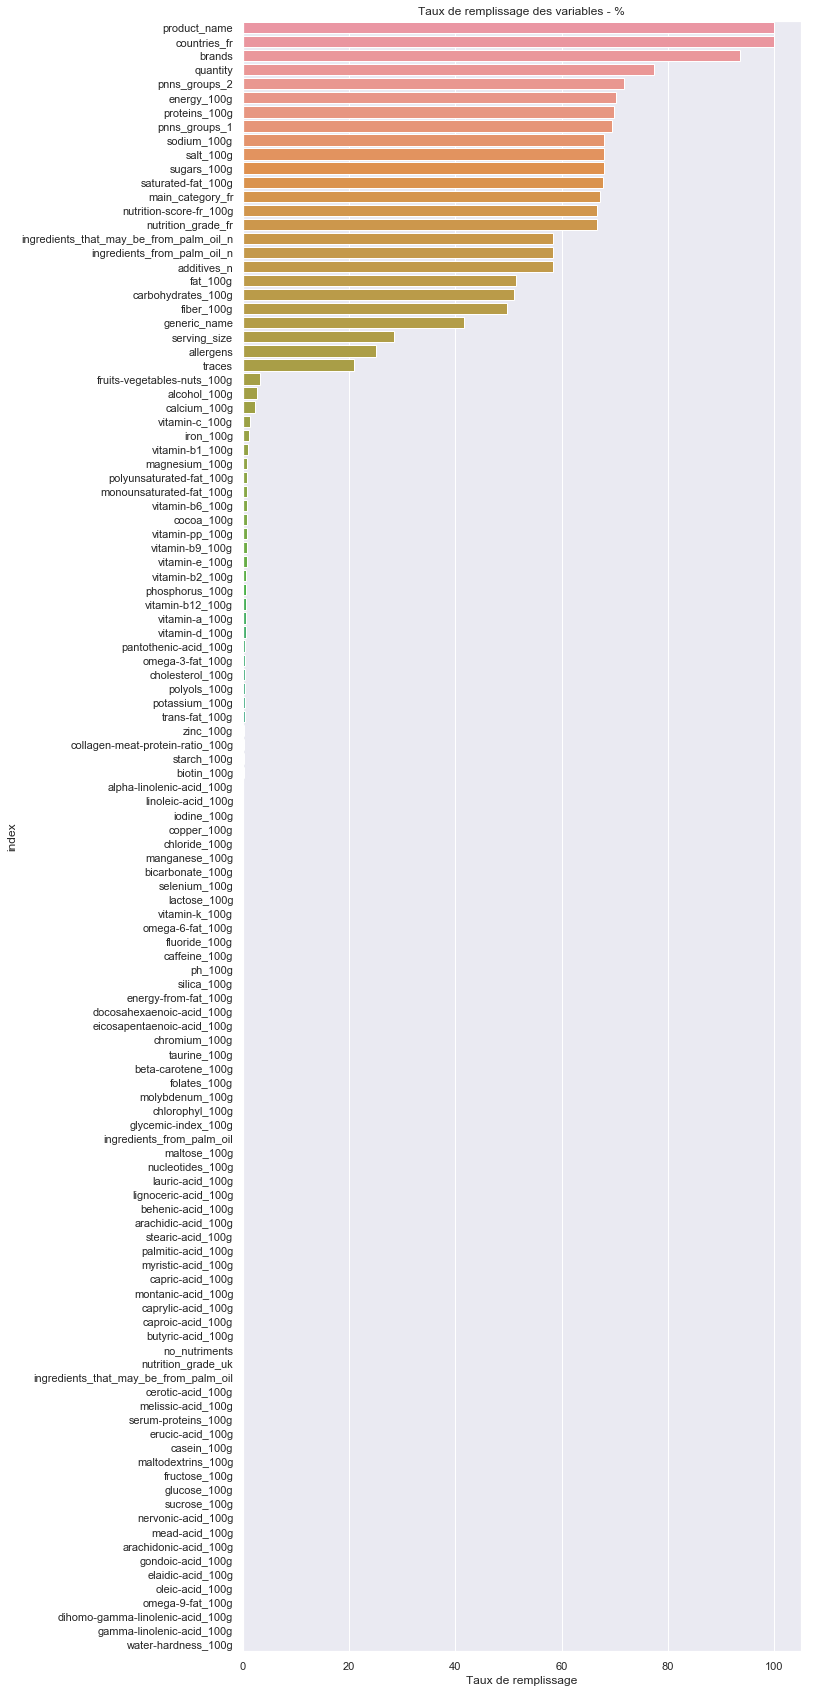

In [12]:
# Calcul du taux de remplissage des colonnes:
df = pd.DataFrame(round(data.count(axis=0)/data.shape[0]*100,2),
             columns=['Taux de remplissage']).sort_values('Taux de remplissage',
                                                          ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(10,30))
sns.barplot(y=df['index'],
             x='Taux de remplissage',
             data=df,
           )
plt.title('Taux de remplissage des variables - %')
plt.show()

In [14]:
# Suppression des COLONNES contenant trop peu de valeurs remplies:
#     Le 'nutrition_score' contient 66721 lignes remplies sur 90536.
#     Choix: remplissage minimum: 2% du remplissage du 'nutrition_score'
#     Cad:  suppression des colonnes avec moins de 1333 lignes remplies.

pourc_min = float(2*100/(df['Taux de remplissage'][df['index']=='nutrition-score-fr_100g']))
L = list(df['index'][df['Taux de remplissage']<pourc_min])
data = data.drop(L, axis='columns')
data.shape

(90534, 26)

In [15]:
# Gestion des NaN pour les nutrition facts: (colonnes avec suffixe _100g):

# Remplacement par des 0 :
L = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
     'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
     'sodium_100g', 'fruits-vegetables-nuts_100g']
data.loc[:,L] = data.loc[:,L].fillna(0)

# Suppression s'ils sont tous = 0 :
data = data[(data.loc[:,L]!=0).any(axis=1)]
data.shape

(64059, 26)

In [16]:
# Gestion des NaN pour le nutrition_score et nutrition_grade:
# ==> Calcul par la formule d'OpenFoodFacts:
#     (on considère qu'il n'y a pas de données manquantes)

def nutri_calcul(row):
    """Fonction calculant le nutrition_score et nutrition_grade"""
    nutri_grade = ''
    nutri_score = 0    
    
    # Si toutes les valeurs sont NaN:
    x = np.isnan(row['sugars_100g'])
    y = np.isnan(row['energy_100g']) 
    z = np.isnan(row['saturated-fat_100g'])
    w = np.isnan(row['sodium_100g'])
    v = np.isnan(row['fruits-vegetables-nuts_100g'])
    u = np.isnan(row['fiber_100g'])
    t = np.isnan(row['proteins_100g'])
    if (t & u & v & w & x & y & z):
        return None,None
    
    # Calcul des points A:
    x = row['sugars_100g']
    if (x<=4.5):
        b = 0
    elif (x>4.5) & (x<=9):
        b = 1
    elif (x>9) & (x<=13.5):
        b = 2
    elif (x>13.5) & (x<=18):
        b = 3
    elif (x>18) & (x<=22.5):
        b = 4
    elif (x>22.5) & (x<=27):
        b = 5
    elif (x>27) & (x<=31):
        b = 6
    elif (x>31) & (x<=36):
        b = 7
    elif (x>36) & (x<=40):
        b = 8
    elif (x>40) & (x<=45):
        b = 9
    elif (x>45):
        b = 10   

    x = row['energy_100g']
    if (x<=335):
        a = 0
    elif (x>335) & (x<=670):
        a = 1
    elif (x>670) & (x<=1005):
        a = 2
    elif (x>1005) & (x<=1340):
        a = 3
    elif (x>1340) & (x<=1675):
        a = 4
    elif (x>1675) & (x<=2010):
        a = 5
    elif (x>2010) & (x<=2345):
        a = 6
    elif (x>2345) & (x<=2680):
        a = 7
    elif (x>2680) & (x<=3015):
        a = 8
    elif (x>3015) & (x<=3350):
        a = 9
    elif (x>3350):
        a = 10  
        
    x = row['saturated-fat_100g']
    if (x<=1):
        c = 0
    elif (x>1) & (x<=2):
        c = 1
    elif (x>2) & (x<=3):
        c = 2
    elif (x>3) & (x<=4):
        c = 3
    elif (x>4) & (x<=5):
        c = 4
    elif (x>5) & (x<=6):
        c = 5
    elif (x>6) & (x<=7):
        c = 6
    elif (x>7) & (x<=8):
        c = 7
    elif (x>8) & (x<=9):
        c = 8
    elif (x>9) & (x<=10):
        c = 9
    elif (x>10):
        c = 10  

    x = row['sodium_100g']
    if (x<=0.09):
        d = 0
    elif (x>0.09) & (x<=0.18):
        d = 1
    elif (x>0.18) & (x<=0.27):
        d = 2
    elif (x>0.27) & (x<=0.36):
        d = 3
    elif (x>0.36) & (x<=0.45):
        d = 4
    elif (x>0.45) & (x<=0.54):
        d = 5
    elif (x>0.54) & (x<=0.63):
        d = 6
    elif (x>0.63) & (x<=0.72):
        d = 7
    elif (x>0.72) & (x<=0.81):
        d = 8
    elif (x>0.81) & (x<=0.9):
        d = 9
    elif (x>0.9):
        d = 10  
        
    A = a+b+c+d      
    
    # Calcul des points C:
    x = row['fruits-vegetables-nuts_100g']
    if (row['pnns_groups_1']=='Beverages'): #Grille spécifique pour les boissons
        if (x<=0.4):
            aa = 0
        elif (x>0.4) & (x<=0.6):
            aa = 2
        elif (x>0.6) & (x<=0.8):
            aa = 4
        elif (x>0.8):
            aa = 10 
    else: #Cas générale
        if (x<=0.4):
            aa = 0
        elif (x>0.4) & (x<=0.6):
            aa = 1
        elif (x>0.6) & (x<=0.8):
            aa = 2
        elif (x>0.8):
            aa = 5    

    x = row['fiber_100g']
    if (x<=0.7):
        bb = 0
    elif (x>0.7) & (x<=1.4):
        bb = 1
    elif (x>1.4) & (x<=2.1):
        bb = 2
    elif (x>2.1) & (x<=2.8):
        bb = 3
    elif (x>2.8) & (x<=3.5):
        bb = 4
    elif (x>3.5):
        bb = 5   
            
    x = row['proteins_100g']
    if (x<=1.6):
        cc = 0
    elif (x>1.6) & (x<=3.2):
        cc = 1
    elif (x>3.2) & (x<=4.8):
        cc = 2
    elif (x>4.8) & (x<=6.4):
        cc = 3
    elif (x>6.4) & (x<=8):
        cc = 4
    elif (x>8):
        cc = 5        
    
    C = aa+bb+cc
    
    #Calcul du nutrition_score:     
    if (A<11) | (row['pnns_groups_2']=='Cheese'):
        nutri_score = A - C
    else:
        if aa == 5:
            nutri_score = A - C
        else:
            nutri_score = A - (aa + bb)
        
    #Calcul du nutrition_grade:
    if (row['pnns_groups_1']!='Beverages'): #Aliments solides
        if nutri_score<=-1:
            nutri_grade = 'a'
        elif (nutri_score>-1) & (nutri_score<=2):
            nutri_grade = 'b'
        elif (nutri_score>2) & (nutri_score<=10):
            nutri_grade = 'c'
        elif (nutri_score>10) & (nutri_score<=18):
            nutri_grade = 'd'
        elif (nutri_score>18):
            nutri_grade = 'e'
    else:                                   # Boissons
        if (row['generic_name']==row['generic_name']):
            x = row['generic_name'].lower()
            if (('eau' in x) | ('water' in x) | ('agua' in x)): # Eau
                nutri_grade = 'a' 
            elif (nutri_score<1) & (nutri_score<=2):
                nutri_grade = 'b'
            elif (nutri_score>2) & (nutri_score<=5):
                nutri_grade = 'c'
            elif (nutri_score>5) & (nutri_score<=9):
                nutri_grade = 'd'
            elif (nutri_score>9):
                nutri_grade = 'e'
        elif (nutri_score<1) & (nutri_score<=2):
            nutri_grade = 'b'
        elif (nutri_score>2) & (nutri_score<=5):
            nutri_grade = 'c'
        elif (nutri_score>5) & (nutri_score<=9):
            nutri_grade = 'd'
        elif (nutri_score>9):
            nutri_grade = 'e'
            
    return nutri_grade, nutri_score


In [17]:
# Remplacement des NaN par les valeurs calculés:

flag = data.loc[:,'nutrition-score-fr_100g'].count()

df1 = data[data['nutrition-score-fr_100g'].isna()] 
df2 = df1[df1['pnns_groups_1'].notna()] 
df = df2[df2['pnns_groups_2'].notna()] 

for index, row in df.iterrows():
    nutri_grade, nutri_score = nutri_calcul(row)
    data.loc[index,'nutrition-score-fr_100g'] = nutri_score
    data.loc[index,'nutrition_grade_fr'] = nutri_grade

print('Nombre de lignes corrigés: ',data.loc[:,'nutrition-score-fr_100g'].count()-flag)

Nombre de lignes corrigés:  3782


In [18]:
# Gestion des NaN restants du nutrition_score: 
#  ==> Prédiction du nutrition_score par régression:
#      (pour les lignes ayant pnns_groups_1 ou pnns_groups_2 vides)


df = data.loc[:,['nutrition-score-fr_100g','energy_100g','fat_100g',
                 'saturated-fat_100g','carbohydrates_100g','sugars_100g',
                 'fiber_100g','proteins_100g','sodium_100g','fruits-vegetables-nuts_100g',
                 'salt_100g']][data['nutrition-score-fr_100g'].notnull()]

y = df['nutrition-score-fr_100g'].values
X = df.drop('nutrition-score-fr_100g', axis='columns').values

from sklearn import preprocessing #standardisation
X_scaled = preprocessing.StandardScaler().fit_transform(X)

from sklearn.model_selection import train_test_split #split train test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=33)

from sklearn.ensemble import BaggingRegressor #bootstrapping aggregation method
reg = BaggingRegressor(n_estimators = 100, #decision tree estimator
                       random_state = 33)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

R2 = reg.score(X_test, y_test)
print('Coeff. de détermination: ',round(R2,2))

from sklearn import metrics
RMSE = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),1)
print("RMSE (values in [-15;40]): ",RMSE)

Coeff. de détermination:  0.96
RMSE (values in [-15;40]):  1.7


In [19]:
# Gestion des NaN restants du nutrition_grade: 
#  (les lignes ayant pnns_groups_1 ou pnns_groups_2 vides)

# Prédiction du nutrition_grade par classification:
# (on aurait aussi pu le déduire du nutrition_score calculé précedemment par régression)

df = data.loc[:,['nutrition_grade_fr','energy_100g','fat_100g',
                 'saturated-fat_100g','carbohydrates_100g','sugars_100g',
                 'fiber_100g','proteins_100g','sodium_100g','fruits-vegetables-nuts_100g',
                 'salt_100g']][data['nutrition_grade_fr'].notnull()]

from sklearn.preprocessing import LabelEncoder #Transformer données textes en chiffres
labelencoder = LabelEncoder()
df['nutrition_grade_fr'] = labelencoder.fit_transform(df['nutrition_grade_fr'])

y = df['nutrition_grade_fr'].values
X = df.drop('nutrition_grade_fr', axis='columns').values

from sklearn import preprocessing #standardisation
X_scaled = preprocessing.StandardScaler().fit_transform(X)

from sklearn.model_selection import train_test_split #split train test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=33)

from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=20,
                             random_state = 33)
clf.fit(X_train, y_train)
Accuracy = clf.score(X_test, y_test)
print('Accuracy (% valeur correcte): ',round(Accuracy,2))

Accuracy (% valeur correcte):  0.91


In [20]:
# Remplacement des NaN par les valeurs prédites:

flag = data.loc[:,'nutrition-score-fr_100g'].count()

df = data.loc[:,['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g',
                 'fiber_100g','proteins_100g','sodium_100g','fruits-vegetables-nuts_100g',
                 'salt_100g']][data['nutrition-score-fr_100g'].isna() | data['nutrition_grade_fr'].isna()]
X = df.values
score_pred = pd.Series(reg.predict(X), index = df.index)
grade_pred = pd.Series(labelencoder.inverse_transform(clf.predict(X)),index = df.index)

for index, row in df.iterrows():
    if np.isnan(data.loc[index,'nutrition-score-fr_100g']):
        data.loc[index,'nutrition-score-fr_100g'] = score_pred[index]
    if np.isnan(data.loc[index,'nutrition_grade_fr']):
        data.loc[index,'nutrition_grade_fr'] = grade_pred[index]

print('Nombre de lignes corrigés: ',data.loc[:,'nutrition-score-fr_100g'].count()-flag)

Nombre de lignes corrigés:  81


#### Gestion d'outliers:

In [21]:
# Recherche d'outliers vu via boxplots:
# A quels produits correspondent ces outliers?

L = ['energy_100g','fat_100g', 'saturated-fat_100g','sugars_100g',
     'fiber_100g','proteins_100g','salt_100g', 'sodium_100g']

for i in range(1,8): # outliers interval: [Q1-1.5*IQR ; Q3+1.5*IQR]
    df = data.loc[:,[L[i-1],'product_name','pnns_groups_1']][data.loc[:,L[i-1]]!=0]
    Q1 = df[L[i-1]].quantile(0.25)
    Q3 = df[L[i-1]].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[L[i-1]]>(Q3+1.5*IQR)) | (df[L[i-1]]<(Q1-1.5*IQR))]
    df.name = L[i-1]
    df = df.sort_values(L[i-1], ascending=False)
    print(df.head(15)) 



        energy_100g                                       product_name  \
223318      15481.0  Huiles vierge biologique de Colza - première p...   
178787       9983.0                                 Halva with Almonds   
224442       9050.0                                   Croûtons à l'ail   
218448       7339.0                      300G TARTINABLE a LA NOISETTE   
250717       7029.0                Gruyère France au lait cru (33% MG)   
240071       6803.0                 Emmental français râpé au lait cru   
219497       6393.0                            16 Mignardises Création   
274490       6268.0                             Nakd Strawberry Crunch   
210322       6138.0                                       Purée Nature   
229618       6134.0                          Boulgour Bio Traditionnel   
229737       6117.0        Eclats De Pois Chiches Bio ? 500G ? Priméal   
207590       6109.0                                  Pains Au Chocolat   
264409       6067.0                   

In [22]:
# Pour le sel, le sucre, le gras: les outliers sont des paquets de sucre, des paquets de sel, 
# des bouteilles d'huile d'olives, ce ne sont pas des valeurs erronnés, ces produits sont 
# utilisés (en faible quantité) dans les recettes, il faut les conserver.

# Pour les protéines et les fibres: on voit certains produits erronés qui ne sont pas des 
# aliments:'Harry Potter & The Deathly Hallows','Le Hobbit : La Bataille Des Cinq Armés'...
# On a aussi une Eau avec 100g de fibres.
# On pourrait supprimer automatiquement les données sans 'pnns_groups' pour s'en débarasser
# mais cela supprime plus de 20% des données ce qui peut être problématique. 
# Suppression manuel de ces éléments.

data = data.drop([273543, 170118, 127525, 283105], axis='index')

#### Taux de remplissage final

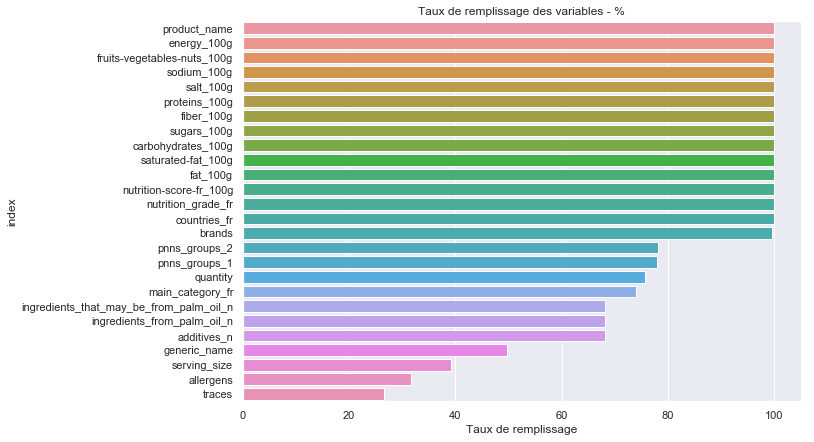

In [23]:
# Visualisation du taux de remplissage des colonnes post-nettoyage:

df = pd.DataFrame(round(data.count(axis=0)/data.shape[0]*100,2),
             columns=['Taux de remplissage']).sort_values('Taux de remplissage',
                                                          ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(y=df['index'],
             x='Taux de remplissage',
             data=df,
           )
plt.title('Taux de remplissage des variables - %')
plt.show()

In [24]:
# Export des données nettoyées:

data.to_csv(os.getcwd()+'\\OpenFoodFact_post_cleaning.csv')

In [25]:
data.shape

(64055, 26)